In [133]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from hyperbolicity.tree_fitting_methods.hdtree import hdtree
from hyperbolicity.delta import compute_exact_hyperbolicity_naive
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

In [188]:
sizes = [15, 15, 15]
probs = [[0.6, 0.15, 0.15],
         [0.15, 0.6, 0.15],
         [0.15, 0.15, 0.6]]
G = nx.stochastic_block_model(sizes, probs, seed=42)
n = len(G.nodes)
print(nx.diameter(G))
true_labels = np.array([G.nodes[i]['block'] for i in range(n)])
n = G.number_of_nodes()
G.add_node(n)
for j in range(n+1):
    G.add_weighted_edges_from([(j, n, 100)])

dist_matrix = nx.floyd_warshall_numpy(G)

3


In [189]:
tree_opt = hdtree(torch.tensor(dist_matrix), 45, 0.1, 1, 45, 100.0, 20, 200, True, True)

Early stopping triggered:  47%|████▋     | 94/200 [00:04<00:04, 21.57it/s]                        


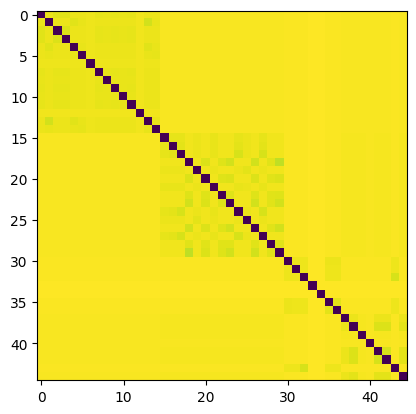

In [185]:
plt.imshow(tree_opt[:-1, :-1])

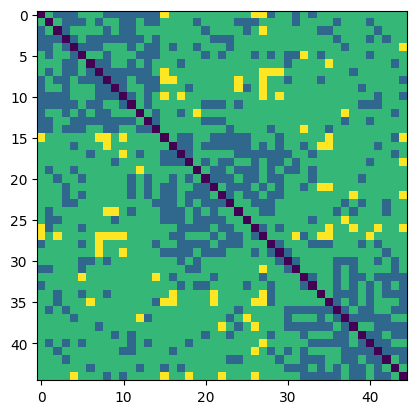

In [186]:
plt.imshow(dist_matrix[:-1, :-1])

In [187]:
Z1 = linkage(dist_matrix[:-1,:-1], method='ward')
Z2 = linkage(tree_opt[:-1,:-1], method='ward')
cluster_labels1 = fcluster(Z1, t=3, criterion='maxclust') 
cluster_labels2 = fcluster(Z2, t=3, criterion='maxclust') 

def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm) 
    return cm[row_ind, col_ind].sum() / np.sum(cm)

print(clustering_accuracy(true_labels, cluster_labels1))
print(clustering_accuracy(true_labels, cluster_labels2))

0.9111111111111111
0.8222222222222222


/tmp/ipykernel_3286608/243381882.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z1 = linkage(dist_matrix[:-1,:-1], method='ward')
/tmp/ipykernel_3286608/243381882.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z2 = linkage(tree_opt[:-1,:-1], method='ward')
